# Describing model predictions, using SHAP values and SHAP interactions

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebooks (03_xgb_combined_shap_key_features.ipynb) we saw that a feature with the same value in multiple instances (such as all of the patients that attend hospital A), the feature (Hospital A) does not necessarily have the same SHAP value in all of those instances. This means that the feature value alone is not a clear indication of the impact it will have on the prediction - this is due to there being feature interactions, such that SHAP values for a feature are influenced by the other feature values. This means that SHAP values are instance dependent (as they are also capturing the interactions between pairs of feature values). The SHAP values therefore are in turn made up of a main effect (what is due to the feature value, the standalone effect) and also the interactions with the other features (a value per feature pairings).

[Note: In this notebook we will refer to the parts of the SHAP value consistently as base value, main effect, and interactions, where the term SHAP feature value refers to the sum of the main effect and interactions].

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values (base, main effect and feature interactions) of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working. At present this is using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

## Model and data

XGBoost model was trained on all of the data (no test set used). The 10 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Onset during sleep: Did stroke occur in sleep?
* Age: Age (as middle of 5 year age bands)

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP main effect and SHAP interaction values
* Understand the SHAP main effect and SHAP interaction values
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* The proportions of the total SHAP coming from the main SHAP effect and SHAP interactions are 0.62 and 0.38 respectively.

## Import modules

In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

import json

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/01_feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

In [5]:
data_loc = '../data/kfold_5fold/'

In [19]:
# Initialise empty lists
train_data, test_data = [], []

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('./output/01_feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in training set, restrict to chosen features, rename titles, & store
    train = pd.read_csv(data_loc + 'train_{0}.csv'.format(i))
    train = train[key_features]
    train.rename(columns=feature_name_dict, inplace=True)
    train_data.append(train)
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=feature_name_dict, inplace=True)
    test_data.append(test)

For this exercise, train the model using all the data. Join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [20]:
data = pd.concat(test_data)

## Fit XGBoost model

Fit XGBoost model

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [21]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [22]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


## One hot encode hospitals

In [23]:
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

In [24]:
model = XGBClassifier(verbosity = 0, random_state=42, learning_rate=0.5)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [25]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [26]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.878


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

In [27]:
# Set up the method to estimate SHAP values for tree models and ensembles of
# trees
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer(X)

The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [28]:
shap_values[0]

.values =
array([ 7.56502628e-01,  4.88319576e-01,  1.10273695e+00,  4.40223962e-01,
        4.98975307e-01,  2.02812225e-01, -2.62601525e-01,  3.69181409e-02,
        2.30234995e-01,  3.20923195e-04, -6.03703642e-03, -7.17267860e-04,
        0.00000000e+00, -4.91688668e-04,  1.20360847e-03,  1.77788886e-03,
       -4.34198463e-03, -2.76021136e-04, -2.79896380e-03,  3.52182891e-03,
       -2.73969141e-04,  8.53505917e-03, -5.28220041e-03, -8.25227005e-04,
        6.20208494e-03,  6.92215608e-03, -6.32244349e-03, -3.35367222e-04,
        7.81939551e-03, -4.71850217e-06, -4.25534381e-05,  6.48253039e-03,
        8.43156071e-04, -6.28353562e-04, -1.25156669e-02, -7.92063680e-03,
       -1.99409085e-03, -5.05548809e-03, -3.90118686e-03,  1.30317558e-03,
        0.00000000e+00, -6.48246554e-04,  1.19629130e-03,  8.26304778e-04,
        1.28053436e-02,  2.55714403e-03, -3.20375757e-03,  4.23251512e-03,
       -7.19791185e-03,  4.02670400e-03,  3.75146419e-03,  8.31848301e-04,
        3.45067

There is one of these for each instance.

In [29]:
shap_values.shape

(88792, 141)

### View SHAP values using beeswarm plot

The beeswarm plot gives a good visual representation of the general SHAP value pattern for the whole dataset. 

Each feature is shown on a separate row. It shows the distribution of the SHAP values for each feature. The colour represents the feature data value, and the shape of the data points represent the distribution of the features SHAP values (with a bulge representing a larger number of points, and a thin row representing fewer points). A SHAP value less than 0 (as seen on the x-axis) contributes to the likelihood that the passenger will not survive, whereas a SHAP value greater than 0 contributes to the likelihood that the passenger will survive.

The actual predction of whether a passenger will survive is the sum of each of the SHAP feature values and the SHAP base value.

Here we see that the first line on the beeswarm represents the feature male. A red data points represents a high data value (a male passenger), and a blue datapoint represents a low data value (a female passenger). Being male contributes to the likelihood that they will not survive, whereas being female contributes to the likelihood that they will survive. Female passengers can have a stronger contribution to the outcome (up to +4) than compared to the males (down to -2).

The third line on the beeswarm represents the feature Age. A red data points represents a high data value (an old passenger), a purple datapoint represents a mid point (a middle aged passenger) and a blue datapoint represents a child. The older the passenger the stronger the contribution to the likelihood that they will not survive, the younger the passenger the stronger the contribution to the likelihood that they will survive. There are more datapoints around the 0 SHAP value (which are coloured purple, and so represent the middle aged passengers) than at the extremes.

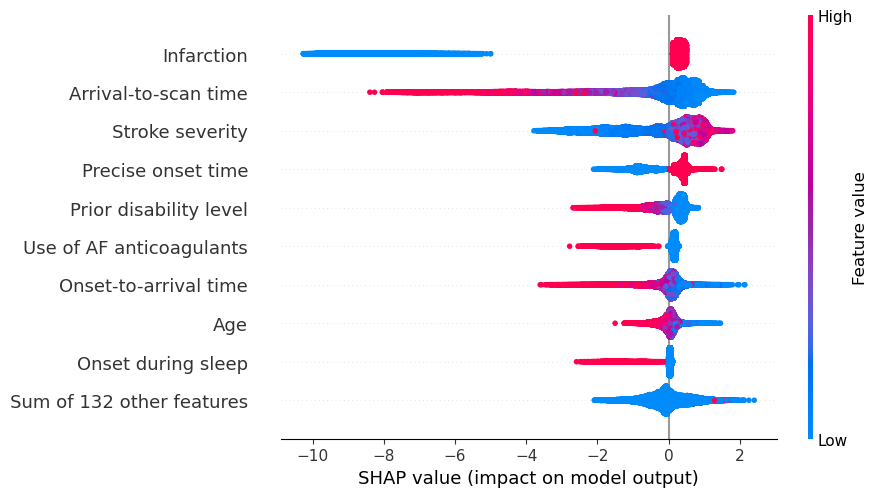

In [30]:
shap.plots.beeswarm(shap_values,show=False)

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP main effect and SHAP interaction values (the sum of which give the SHAP values for each feature).

In [31]:
# Get SHAP interaction values
shap_interaction = explainer.shap_interaction_values(X)

SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 891 instances has a 4x4 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [32]:
shap_interaction.shape

(88792, 141, 141)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [33]:
shap_interaction[0]

array([[ 6.76276624e-01,  4.08733338e-02,  1.05852485e-02, ...,
         1.75262336e-04,  1.55542511e-05, -3.98763688e-04],
       [ 4.08733785e-02,  3.38386327e-01,  5.30318618e-02, ...,
         0.00000000e+00,  0.00000000e+00,  6.54254109e-07],
       [ 1.05856061e-02,  5.30319214e-02,  8.62581849e-01, ...,
         1.82669377e-04,  3.62747931e-04,  8.75864644e-05],
       ...,
       [ 1.75237656e-04,  0.00000000e+00,  1.82688236e-04, ...,
         3.14869266e-03,  0.00000000e+00,  3.90200876e-06],
       [ 1.55568123e-05,  0.00000000e+00,  3.62753868e-04, ...,
         0.00000000e+00, -1.80786219e-03,  0.00000000e+00],
       [-3.98725271e-04,  6.55651093e-07,  8.76188278e-05, ...,
         3.90200876e-06,  0.00000000e+00,  3.13467532e-03]], dtype=float32)

### SHAP interaction matrix: show mean absolute values
Here we see the absolute mean of the SHAP interaction values for all of the instances.\
The values on the diagonal show the main effect for the feature, and the other values show the SHAP interaction for pairs of features (these are symetrical across the diagonal)

In [34]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction).mean(axis=(0)),
    index=X.columns, columns=X.columns)

mean_abs_interactions.round(2)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulants,Onset-to-arrival time,Onset during sleep,Age,team_AGNOF1041H,...,team_XKAWN3771U,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C
Arrival-to-scan time,1.02,0.09,0.09,0.03,0.04,0.02,0.10,0.01,0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
Infarction,0.09,1.56,0.10,0.07,0.04,0.03,0.02,0.01,0.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
Stroke severity,0.09,0.10,0.92,0.06,0.05,0.02,0.04,0.01,0.03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
Precise onset time,0.03,0.07,0.06,0.58,0.02,0.01,0.01,0.02,0.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
Prior disability level,0.04,0.04,0.05,0.02,0.39,0.01,0.02,0.00,0.03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
team_YPKYH1768F,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
team_YQMZV4284N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
team_ZBVSO0975W,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.00
team_ZHCLE1578P,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00


### The proportion of SHAP that is from the interactions: calculated from the absolute mean
Looking at all of the instances together, what proportion of the SHAP value comes from the SHAP interations

In [35]:
total_shap = mean_abs_interactions.sum().sum()

interaction_shap = (mean_abs_interactions.sum().sum() - 
                    np.diagonal(mean_abs_interactions).sum().sum())

print(f'The proportion of the SHAP values coming from the interactions are: '
      f'{interaction_shap/total_shap:0.3f}')
print(f'The proportion of the SHAP values coming from the main effects are: '
      f'{1 - (interaction_shap/total_shap):0.3f}')

The proportion of the SHAP values coming from the interactions are: 0.382
The proportion of the SHAP values coming from the main effects are: 0.618


### The proportion of SHAP that is from the interactions: calculated per instance from the absolute values
Looking at each instances, what proportion of the SHAP value comes from the SHAP interations. Show the range of proportions (one per instance) as a histogram.

Text(0, 0.5, 'Number of instances')

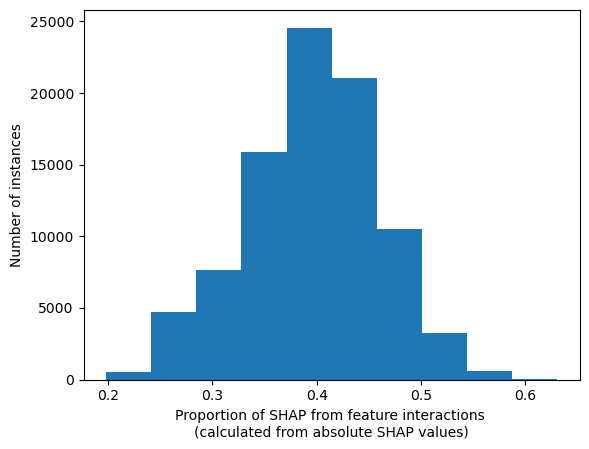

In [36]:
# sum the absolute interaction matrix per instance
abs_total_shap_per_instance = np.abs(shap_interaction).sum(axis=(1,2))

# Initialise list
proportion_interaction = []

# For each instance
for i in range(abs_total_shap_per_instance.shape[0]):
    # sum the absolute feature interactions (off diagonal positions)
    abs_interaction = (abs_total_shap_per_instance[i] - 
                       np.diagonal(np.abs(shap_interaction[i])).sum())
    # calculate the proportion from feature interactions
    proportion_interaction.append(
                abs_interaction / abs_total_shap_per_instance[i])

# plot as histogram
plt.hist(proportion_interaction);
plt.xlabel("Proportion of SHAP from feature interactions \n"
           "(calculated from absolute SHAP values)")
plt.ylabel("Number of instances")

### SHAP interaction matrix: represented as histograms 

Show the distribution of all of the instance values for each SHAP interation and SHAP main effect.

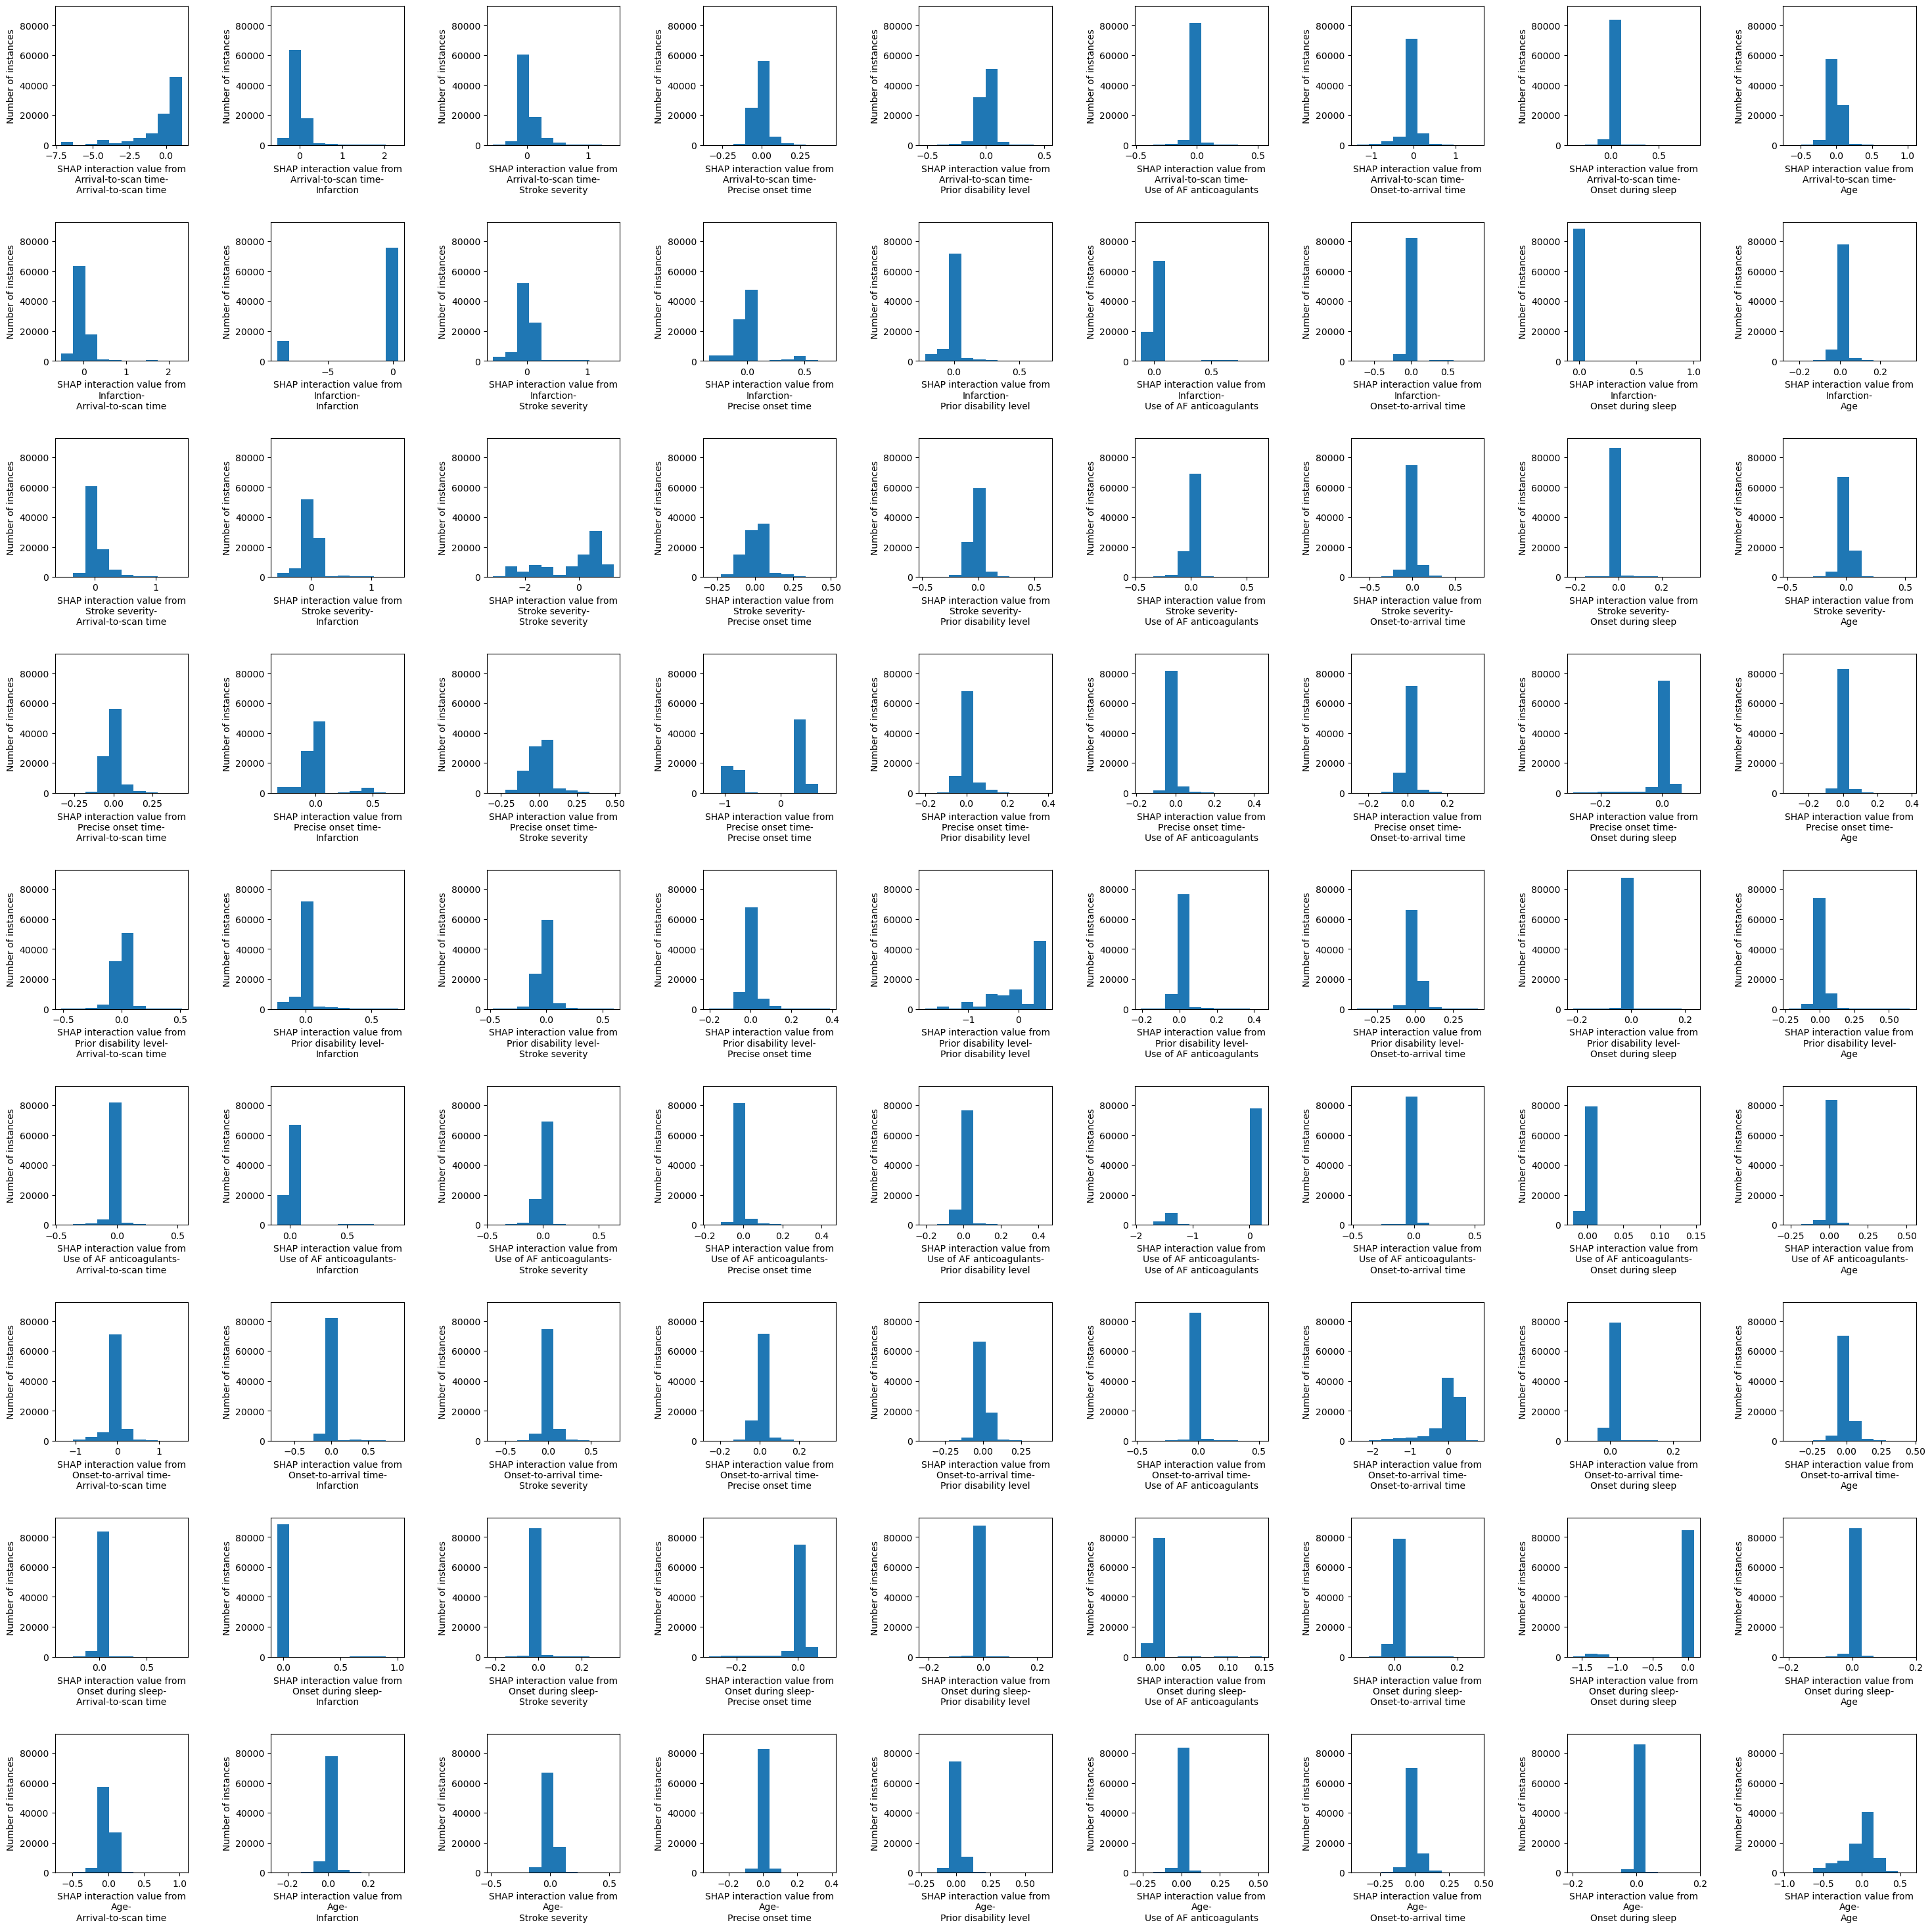

In [59]:
features = list(X)[0:9]
n_features = len(features)

# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
fig, axes = plt.subplots(1)
for i in range(n_features):
    for j in range(n_features):    
        axes.hist(shap_interaction[:,i,j])
        ylims = axes.get_ylim()
        # Store if greater than found so far
        y_max = max(y_max, ylims[1])
# Don't display plot
plt.close(fig)

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()        

count = 0
for i in range(n_features):
    for j in range(n_features):    
        ax=axes[count]
        ax.hist(shap_interaction[:,i,j])
        ax.set_xlabel(f"SHAP interaction value from\n{features[i]}-\n{features[j]}")
        ax.set_ylabel("Number of instances")
        ax.set_ylim(0, y_max)
        count += 1
        
fig.set_figheight(30)
fig.set_figwidth(30)
plt.tight_layout(pad=3)
plt.savefig('./output/12a_shap_interactions_hist.jpg', dpi=300)
plt.show()

## Show a worked example for the first instance
Start with the feature values, and then show the SHAP values and how they can be represented as main effect and interactions. Also show that by summing them along with the base value gives the model output.

In [46]:
instance = 0
target_category = ["No thrombolysis", "Thrombolysis"]
# Show data for first example
print ('Showing a worked example for the first instance')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X.iloc[instance])

# Model output
prob_survive = y_proba[instance][1]
logodds_survive = np.log(prob_survive/(1 -prob_survive))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [no thrombolysis, thrombolysis]: ' +
       f'{np.round(y_proba[instance],3)}')
##print ('------------')
#print (np.round(y_proba[instance],3))
print (f'\n2. Model log odds thrombolysis: {round(logodds_survive,3)}')
#print ('------------')
#print(round(logodds_survive,3))
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
##print ('------------')
#print (y_pred[instance])

print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
 
#example_shap = pd.DataFrame(shap_values.values[instance],columns=X.columns)
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
v = shap_values.values[instance][0]
print (f'{X.columns.values[0]}: {v:0.3f}')
v = shap_values.values[instance][1]
print (f'{X.columns.values[1]}: {v:0.3f}')
v = shap_values.values[instance][2]
print (f'{X.columns.values[2]}: {v:0.3f}')
v = shap_values.values[instance][3]
print (f'{X.columns.values[3]}: {v:0.3f}')
# print (shap_values.values[instance])
v = shap_values.values[instance].sum()
print (f'Total = {v:0.3f}')

print ('\nNote: These are patient dependent')
#print ()
#print ('-----------------')
#print ('Sum of SHAP values')
#print ('------------')
#print (shap_values.values[instance].sum())

print (f'\nThe "Model log odds thrombolysis" value ({logodds_survive:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values.values[instance].sum():0.3f}, see above)')
print (f'{shap_values.base_values[instance]:0.3f} + ' +
       f'{shap_values.values[instance].sum():0.3f} = ' +
       f'{logodds_survive:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction[instance],
                                   index=X.columns,columns=X.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the first instance

------------------
Feature data values
------------------
Arrival-to-scan time      17.0
Infarction                 1.0
Stroke severity           14.0
Precise onset time         1.0
Prior disability level     0.0
                          ... 
team_YPKYH1768F            0.0
team_YQMZV4284N            0.0
team_ZBVSO0975W            0.0
team_ZHCLE1578P            0.0
team_ZRRCV7012C            0.0
Name: 0, Length: 141, dtype: float64

-------------------
Model output values
-------------------
1. Model probability [no thrombolysis, thrombolysis]: [0.096 0.904]

2. Model log odds thrombolysis: 2.247

3. Model classification: 1 (Thrombolysis)

-----------------
SHAP base value (log odds)
---------------
-1.1629876

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
------------
Arrival-to-scan time: 0.757
Infarction: 0.

## Sum of the SHAP value components (base + main effects + interactions) = model prediction 
We've seen a worked through example for one instance that the sum of the SHAP interactions and main effects and base value equals the model output (the log odds of predicted P). 

Here we show that it holds for all of the instances.

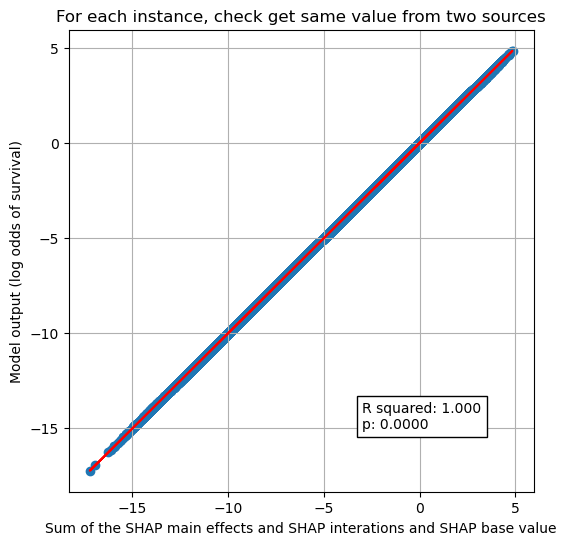

In [49]:
# Model output: probability thrombolysis
prob_thrombolysis = y_proba[:,1]
# Calculate log odds
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))

# sum each matrix to get a value per instance
total_shap_per_instance = shap_values.base_values + shap_interaction.sum(axis=(1,2))

x = total_shap_per_instance
y = logodds_thrombolysis

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(-3, -15, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel("Sum of the SHAP main effects and SHAP interations and SHAP base value")
ax1.set_ylabel("Model output (log odds of survival)")
plt.title("For each instance, check get same value from two sources")
plt.grid()

plt.show()